In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os

from ourfunctions_v3 import clean_nan_samples, try_clf, apply_feature_selection

In [2]:
m = 2000; M = 12000; 
bin_size = 5
step_size = 1; # interpolation step size

path = "D:/GitHub/Machine-Learning/Kaggle/"

In [3]:
savepath = path + 'Kaggle classifiers/bin size 5/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;

In [4]:
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

In [5]:
def remove_noise(df):
    N = len(df)  # number of samples
    idx_list = []
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]

        if np.var(intensity) < 100:
          idx_list.append(idx)
          print('Training sample', idx, ' eliminated')
    new_df = df.drop(index = idx_list)
    return new_df

In [6]:
df_train = remove_noise(df_train)

Training sample 339  eliminated
Training sample 490  eliminated


In [7]:
def interpolate_spectra(df, m, M, step_size):
    # step_size is the size of each step; 1 interpolates very well.
    mz_range = np.arange(m,M+1,step_size)
    
    N = len(df)  # number of samples
    L = len(mz_range)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    idx_list = []
    
    for idx in range(N): 
        intensity = df[['intensity']].iloc[idx].values[0]       
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        interpolated_spectrum = np.interp(x=mz_range,xp=mzcoord,fp=intensity)
        interpolated_spectrum = interpolated_spectrum / np.max(interpolated_spectrum)
        plt.plot(interpolated_spectrum)
        all_data[idx,:] = interpolated_spectrum
    new_df = pd.DataFrame(data=all_data, columns = mz_range, index = df.index)
    plt.show()
    return new_df

Training samples: 359 and test_train samples: 155


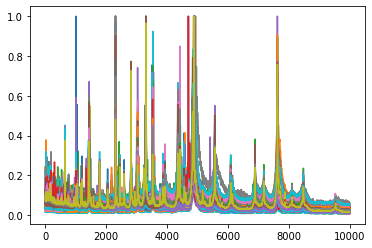

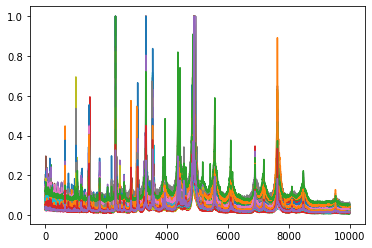

Spectrum interpolated!


In [8]:
# df_train = df_train.drop_duplicates(subset='ID_sample') # eliminate duplicates
# Let's work without duplicates from now on, to avoid having same sample in training and test_training sets

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=0) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

# apply the bins to all spectra, so that our feature space becomes the same for all samples (make them regular, all the same)
spectrum_train = interpolate_spectra(data_train,m,M,step_size)
spectrum_test_train = interpolate_spectra(data_test_train,m,M,step_size)
print('Spectrum interpolated!')
# these spectrum_... are our X for training

In [9]:
categories = targets_train.columns[:]  
c = 0
cat = categories[c]
print(cat)
X_train, Y_train = clean_nan_samples(spectrum_train,targets_train, c, cat)
X = X_train.to_numpy()
Y = Y_train.reshape(-1,1)
from sklearn.cross_decomposition import PLSCanonical
plsca = PLSCanonical(n_components = 50)
plsca.fit(X,Y)
print(X.shape)
print(Y.shape)

OXACILINA
(359, 10001)
(359, 1)


C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\sklearn\cross_decomposition\_pls.py:321: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


In [10]:
plsca.n_iter_

[1]

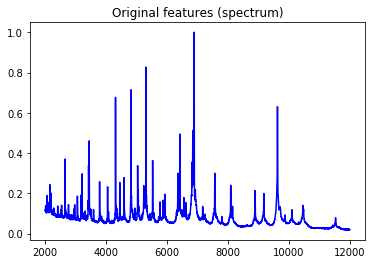

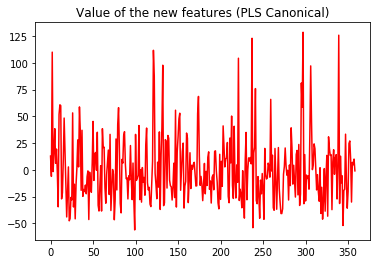

In [11]:
transf_X = plsca.predict(X_train)

plt.plot(X_train.iloc[0,:],'b')
plt.title('Original features (spectrum)')
plt.show()
plt.plot(transf_X,'r')
plt.title('Value of the new features (PLS Canonical)')
plt.show()

In [12]:
X_transf, Y_transf = plsca.transform(X,Y)
print(X_transf[0,:])
print(Y_transf)

[-25.83772428   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
[ 1.33340891 -0.74786847  1.33340891  1.33340891 -0.74786847 -0.74786847
  1.33340891  1.33340891 -0.74786847 -0.74786847  1.33340891 -0.74786847
 -0.74786847  1.33340891 -0.74786847 -0.74786847  1.33340891  1.33340891
 -0.74786847  1.33340891 -0.74786847 -0.74786847 -0.74786847  1.33340891
 -0.74786847 -0.74786847 -0.74786847 -0.74786847  1.33340891 -0.74786847
  1.33340891 -0.74786847 -0.74786847  1.333408